In [1]:
# Exploratory Data Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
from datetime import datetime as date
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  This is definitely going
#  to need further investigation.
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

# Create age ranges of decades.  For some reason, decades can't be used as a column header.
df['tens'] = [int((age // 10) * 10) for age in df.age] 

# Check that everything worked.  In this EDA, there should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 14 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28808 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
tens                     28808 non-null int64
dtypes: datetime64[ns](2), int64(5), object(7)
memory usage: 3.1+ MB


In [3]:
# Separate out the two datasets, misdemeanor (primary) and felony.
felony_df = df.loc[df['offense_class'].str.endswith('F')]
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

# Bin edges to more easily see age differences.
bin_edges = [10, 20, 30, 40, 50, 60, 70, 80, 90] 

# Bin edges for non-age plots.  Sqrt to avoid 'bin bias.'
bins_sqrt = int(np.sqrt(len(misdemeanor_df.bond_amount))) 

# Set up an ecdf function to quickly see distributions.
def ecdf(data):
    '''Compute continuous distribution function for one column'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# And for reference, the number of bins in non-age plots:
bins_sqrt

98

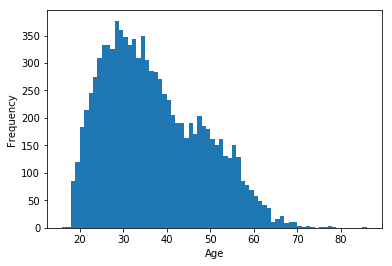

34.0

In [4]:
# Plot the ages and ecdf of ages in one-year increments to see where we start.
misdemeanor_df_bins = misdemeanor_df.age.max() - misdemeanor_df.age.min() # Comes to 70, one for each age in sample
ax = misdemeanor_df.age.plot(kind='hist', bins=misdemeanor_df_bins)
ax = plt.xlabel('Age')
ax = plt.ylabel('Frequency')
plt.show()
misdemeanor_df.age.median()

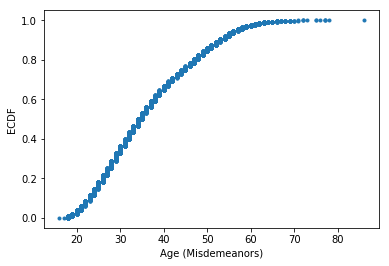

In [5]:
x_age, y_age = ecdf(misdemeanor_df.age)
ax = plt.plot(x_age, y_age, marker='.', linestyle='none')
ax = plt.xlabel('Age (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

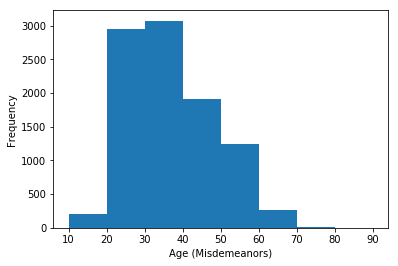

34.0

In [6]:
# Bins of decades to see the how the ages are distributed overall.
ax = misdemeanor_df.age.plot(kind='hist', bins=bin_edges)
ax = plt.xlabel('Age (Misdemeanors)')
ax = plt.ylabel('Frequency')
plt.show()
misdemeanor_df.age.median()

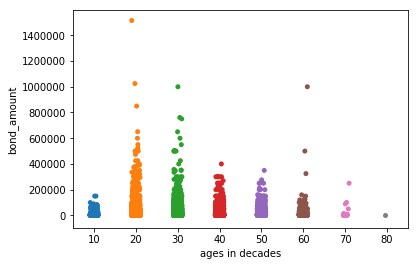

In [7]:
# Start some comparisons of ages against other columns.

# Quick plot where bonds is checked against ages in decades to check for anything
# interesting.  
_ = sns.stripplot(misdemeanor_df.tens, misdemeanor_df.bond_amount)
_ = plt.xlabel('ages in decades')

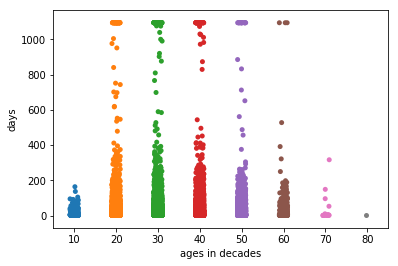

In [8]:
# Quick plots where days detained is checked against ages in decades.
_ = sns.stripplot(misdemeanor_df.tens, misdemeanor_df.days)
_ = plt.xlabel('ages in decades')

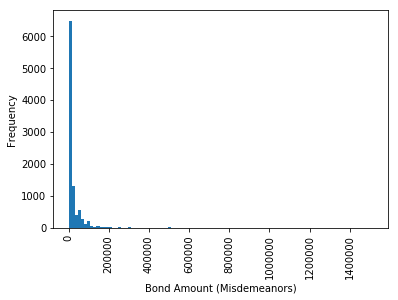

In [9]:
# Plot the misdemeanor bonds.  Most bonds are obviously below 200k.
# We'll look at a zoom later.
ax = misdemeanor_df.bond_amount.plot(kind='hist', bins=bins_sqrt)
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('Frequency')
ax = plt.xticks(rotation=90)
plt.show()

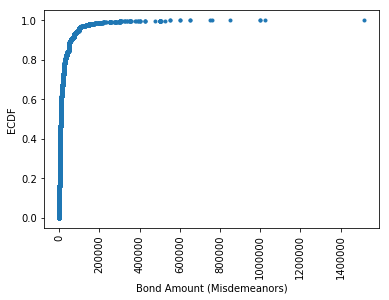

In [10]:
# ECDF of the bond amount distribution.  There are some very high bonds in here.
x_bond, y_bond = ecdf(misdemeanor_df.bond_amount)
ax = plt.plot(x_bond, y_bond, marker='.', linestyle='none')
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('ECDF')
ax = plt.xticks(rotation=90)
plt.show()

In [11]:
# How many of bond amounts are significantly higher?
len(misdemeanor_df.loc[misdemeanor_df.bond_amount >= 400000])

33

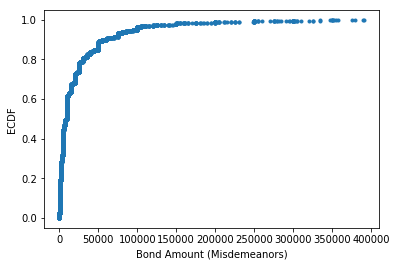

In [12]:
# Check ECDF without those high bonds.  A large number of the bonds are below 80,000.
x_bond, y_bond = ecdf(misdemeanor_df.bond_amount)
x_bond = x_bond[:-33]
y_bond = y_bond[:-33]
ax = plt.plot(x_bond, y_bond, marker='.', linestyle='none')
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

In [13]:
# How many of bond amounts are below 80,000?  How many are above?
print(len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000]), 'below $80k, ', 
      len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000])/len(misdemeanor_df))
print(len(misdemeanor_df.loc[misdemeanor_df.bond_amount > 80000]), 'above $80k, ',
      len(misdemeanor_df.loc[misdemeanor_df.bond_amount > 80000])/len(misdemeanor_df))

# HOw many below 5,000?
print(len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 5000]), 'below $5k, ', 
      len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 5000])/len(misdemeanor_df))

# How many below 1,000?
print(len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 1000]), 'below $1k, ', 
      len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 1000])/len(misdemeanor_df))

# What's the 50th percentile?
print(np.percentile(misdemeanor_df.bond_amount, 50), '50th percentile')

9046 below $80k,  0.9360513245033113
618 above $80k,  0.06394867549668874
4215 below $5k,  0.4361548013245033
1572 below $1k,  0.1626655629139073
9000.0 50th percentile


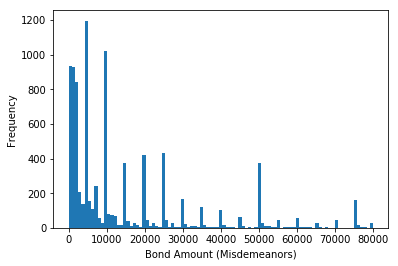

In [14]:
# Not pretty, but shows that bonds are frequently set at numbers divisible by 0 and 5.
bins_80k = int(np.sqrt(len(misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000])))
plot_80k_df = misdemeanor_df.loc[misdemeanor_df.bond_amount <= 80000]
ax = plot_80k_df.bond_amount.plot(kind='hist', bins=bins_80k)
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('Frequency')

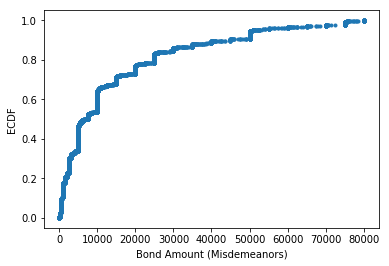

In [15]:
# Distribution of the sub-80k bonds.  
x_bond_80k, y_bond_80k = ecdf(plot_80k_df.bond_amount)
ax = plt.plot(x_bond_80k, y_bond_80k, marker='.', linestyle='none')
ax = plt.xlabel('Bond Amount (Misdemeanors)')
ax = plt.ylabel('ECDF')
plt.show()

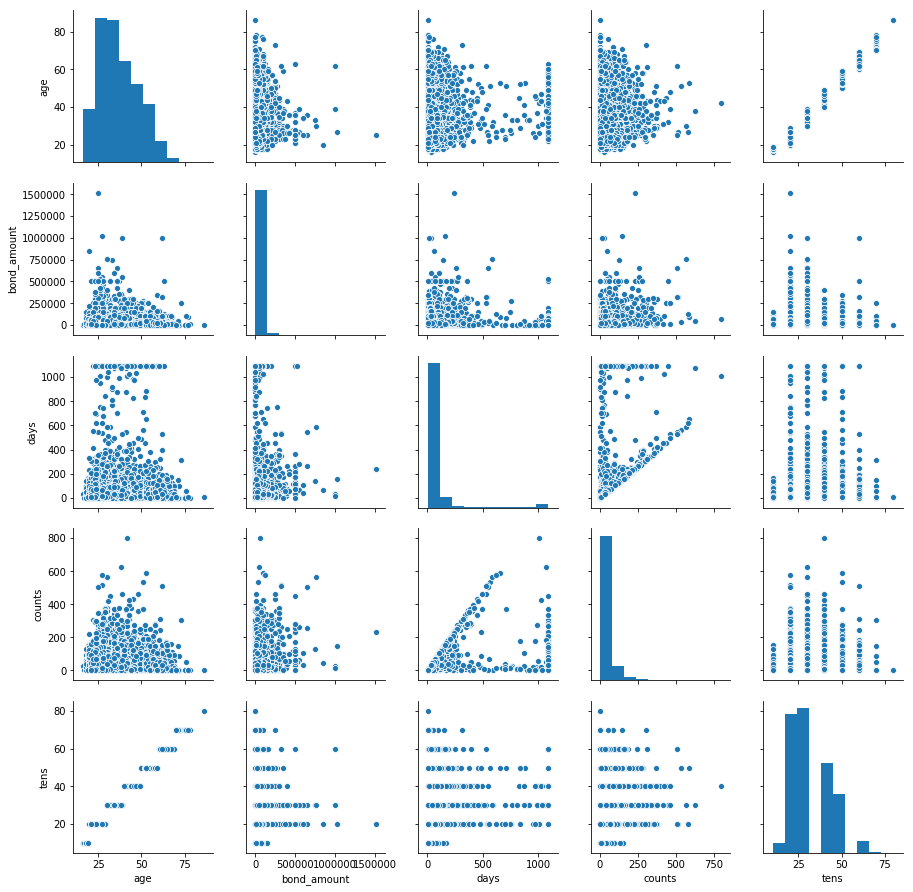

In [16]:
# Just an overview of all the relationships.  The counts vs. days plots are 
# interesting.  Counts is the number of times a detainee is observed in the 
# dataset.  This will obviously be skewed low for anyone already in the system 
# on 2016-07-01, but the state admits that the days calculation (using 
# latest_admission_date) might be the original date the detainee was entered 
# into the CT system instead of the date of entry of this offense.  (Reminder, 
# days is capped at 1,095.  Counts caps at 730, the number of days in the sample.)
# Tens is ages in decades, so there should be a very strong match between the two.
_ = sns.pairplot(misdemeanor_df)

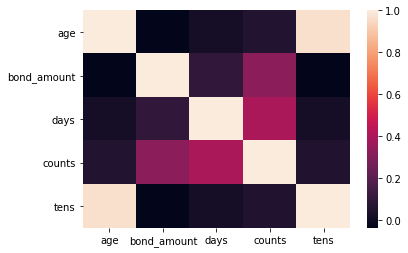

In [17]:
# A heatmap to show correlation between the variables.  Mild correlation
# at most, except for ages/tens in the corners.
corr = misdemeanor_df.corr()
_ = sns.heatmap(corr)

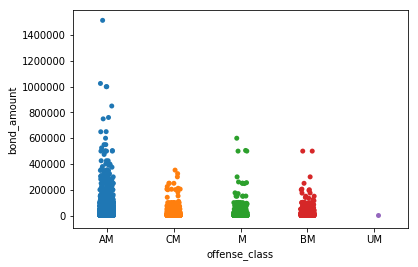

In [18]:
# Now check into the distribution of charges and bond amounts.
# A-class misdemeanors (highest level) show higher - or at least more 
# varied - bonds.
ax = sns.stripplot(x='offense_class', y='bond_amount', data=misdemeanor_df)

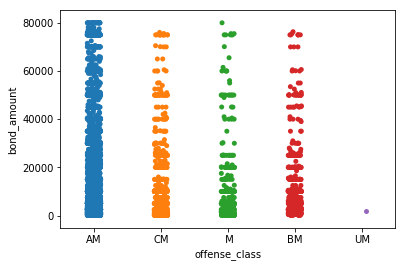

In [19]:
# Zoom of the above plot using the <= 80k dataframe.  A-class misdemeanors are
# more varied.
ax = sns.stripplot(x='offense_class', y='bond_amount', data=plot_80k_df)

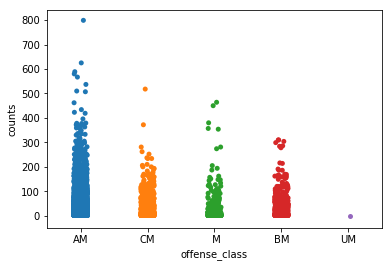

In [20]:
# Offense class vs. days detained.  A-class appears to spend more time
# in custody before bonding out or going to trial.
ax = sns.stripplot(x='offense_class', y='counts', data=misdemeanor_df)

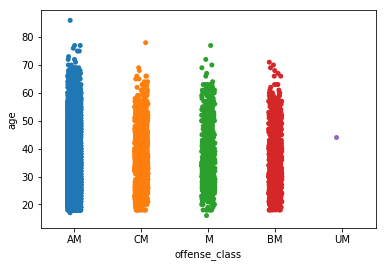

In [21]:
# Offense class vs. age.  I am a little surprised.  I thought the higher
# offenses would skew younger, but maybe the number of offenses is playing
# percerption tricks.
ax = sns.stripplot(x='offense_class', y='age', data=misdemeanor_df)

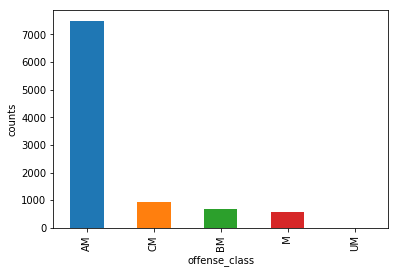

In [22]:
# Counts per offense class.  A-class misdemeanors account for the majority 
# of the sample.  This is why the strip plot for AM is more difficult to 
# make assumptions about.
_ = misdemeanor_df['offense_class'].value_counts().plot(kind='bar')
_ = plt.xlabel('offense_class')
_ = plt.ylabel('counts')

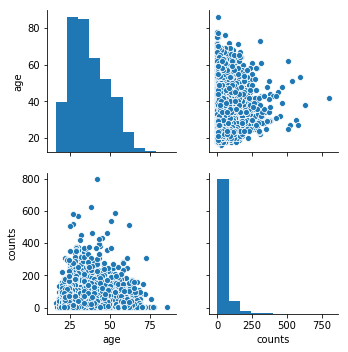

In [23]:
# Age vs. counts.  Older people appear to be released sooner.
_ = sns.pairplot(misdemeanor_df, vars=['age', 'counts'])

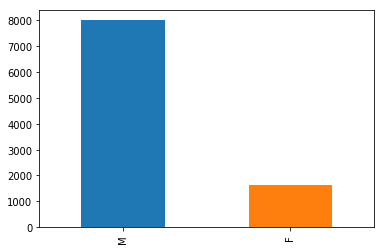

In [24]:
# Count how many detainees are male/female.
_ = misdemeanor_df['gender'].value_counts().plot(kind='bar')

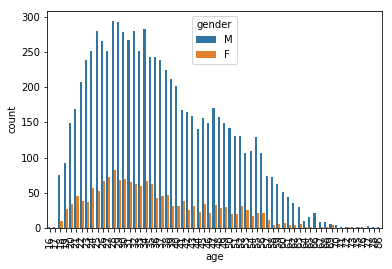

In [25]:
# Compare the ages for both genders in the sample.
_ = sns.countplot(x='age', hue='gender', data=misdemeanor_df)
_ = plt.xticks(rotation=90)

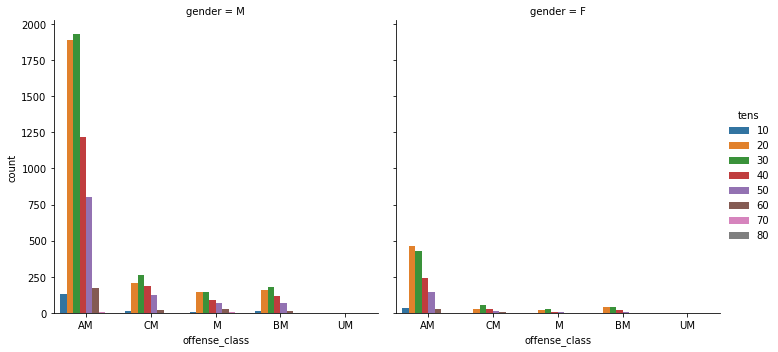

In [26]:
# Check gender distributions of the offense classes against ages in decades.
_ = sns.catplot(x="offense_class", hue="tens", data=misdemeanor_df, kind='count', col='gender');

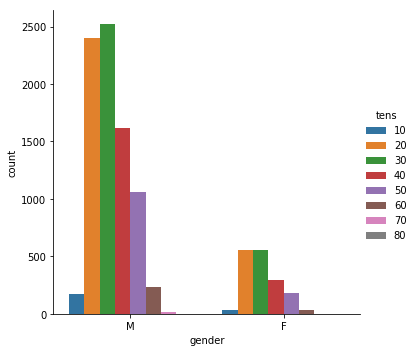

In [27]:
# It looks like the A-class misdemeanors above have a slightly different age/gender 
# distribution.  How do misdemeanors as a whole look in this age/gender grouping?
_ = sns.catplot(x="gender", hue="tens", data=misdemeanor_df, kind='count');

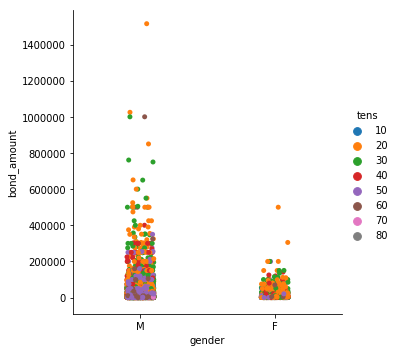

In [28]:
# Check gender distributions of the bond amounts against ages in decades.
# Bonds for female detainees seem to fall more in line with the entire sample
# bond graph that showed that most bonds were below 100k.
_ = sns.catplot(x="gender", hue="tens", data=misdemeanor_df, y='bond_amount');

C:\Users\Misty\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


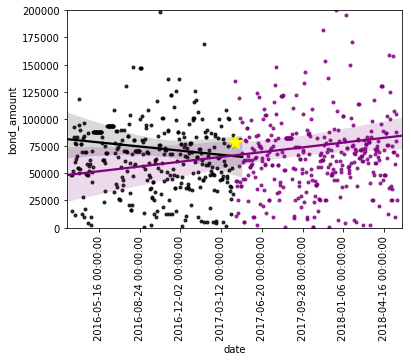

In [29]:
# The bill was itended to reduce cash bond amounts for lower-income detainees.  What
# happened to the average bond in the time before and after enactment?  Note the y-axis
# limits.  The full plot is useless since 93% of bonds are smaller than 80k.  Y-axis
# is zoomed to show the regression line.

datelist = pd.date_range(start='7/1/2016', end='6/30/2018', freq='D').tolist()
dates_df_a = pd.DataFrame({'date':datelist})
dates_df_a['date_ordinal'] = pd.to_datetime(dates_df_a['date']).apply(lambda date: date.toordinal())
dates_df_a['bond_amount'] = [df.bond_amount.loc[df.download_date == date].mean() 
                           if df.bond_amount.loc[df.download_date == date].mean() > 0 
                           else np.nan for date in dates_df_a.date]
dates_df_a.bond_amount = dates_df_a.bond_amount.fillna(method='ffill')

dates_a = dates_df_a.loc[dates_df_a.date < '7/1/2017']
dates_b = dates_df_a.loc[dates_df_a.date >= '7/1/2017']
x_point = dates_df_a['date'].loc[dates_df_a.date == '2017-07-01']
y_point = dates_df_a['bond_amount'].loc[dates_df_a.date == '2017-07-01']

#Make a plot with the ordinals on the date axis
ax = sns.regplot(data=dates_a, x='date_ordinal', y='bond_amount', marker='.', color='black')
ax = sns.regplot(data=dates_b, x='date_ordinal', y='bond_amount', marker='.', color='purple')
# Tighten up the axes for prettiness
ax.set_xlim(dates_a['date_ordinal'].min() - 10, dates_b['date_ordinal'].max() + 10)
ax.set_ylim(0, 200000)
#Replace the ordinal X-axis labels with nice, readable dates
ax.set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax = plt.setp(ax.get_xticklabels(), rotation=90)
# Add star for day bill enacted
ax = plt.plot(x_point, y_point, marker='*', color='yellow', markersize=15)

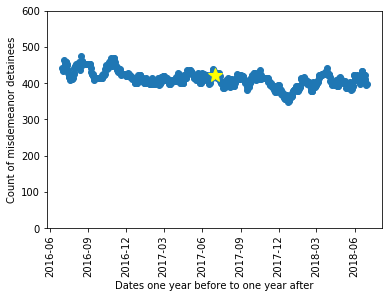

In [30]:
# This block (and next 2) is entirely to get a count of the misdemeanor detainees the state
# claims to hold each day to see if the number changes.  Plot is 2016-07-01 through
# 2018-06-30.  Star is enactment date of 2017-07-01.

# Select the file created in CT_csv (unit 5 data wrangling assignment)
temp_file = 'count.csv'
# Read in the file
counts_df = pd.read_csv(temp_file, parse_dates=['download_date'])
counts_df.drop_duplicates(inplace=True)
# Set the dates and new df.
datelist = pd.date_range(start='7/1/2016', end='6/30/2018', freq='D').tolist()
dates_df = pd.DataFrame({'date':datelist})
# Separate out the Ms and count them.  Forward-fill any zeros (if CT didn't supply 
# data for a day) with the previous day's numbers.
mis_df = counts_df.loc[counts_df.offense_class.str.endswith('M', na=False)] 
dates_df['detainees'] = [mis_df.download_date.loc[mis_df.download_date == date].count() 
                         if mis_df.download_date.loc[mis_df.download_date == date].count() > 0
                         else np.nan for date in dates_df.date]
dates_df['detainees'] = dates_df['detainees'].fillna(method='ffill')
x_point = dates_df['date'].loc[dates_df.date == '2017-07-01']
y_point = dates_df['detainees'].loc[dates_df.date == '2017-07-01']

# Plot the count of misdemeanor detainees for each day to see if there are any trends.
_ = plt.plot_date(x='date', y='detainees', data=dates_df)
_ = plt.ylim(0, 600)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Dates one year before to one year after')
_ = plt.ylabel('Count of misdemeanor detainees')
# Add star for day bill enacted
_ = plt.plot(x_point, y_point, marker='*', color='yellow', markersize=15)

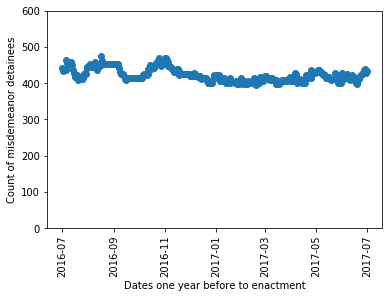

In [31]:
# Check the pre-bill dates on zoom.

pre_dates_df = dates_df.loc[dates_df.date < '2017-07-01']
_ = plt.plot_date(x='date', y='detainees', data=pre_dates_df)
_ = plt.ylim(0, 600)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Dates one year before to enactment')
_ = plt.ylabel('Count of misdemeanor detainees')

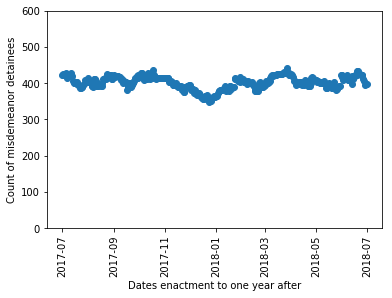

In [32]:
# Check the post-bill dates on zoom.  After looking at these, I don't
# have a visual understanding of if the bill changed anything.  (It does 
# appear that the first year after the bill was lower, but that changes
# about thirteen months after passage - see below for my concerns.)

post_dates_df = dates_df.loc[dates_df.date >= '2017-07-01']
_ = plt.plot_date(x='date', y='detainees', data=post_dates_df)
_ = plt.ylim(0, 600)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Dates enactment to one year after')
_ = plt.ylabel('Count of misdemeanor detainees')

# Conclusions

I've visually examined the ages, bond amounts, classes of offense, and gender individually and against each other.  

The median bond amount is 9,000 USD, with over 93 percent of the misdemeanor bonds below 80,000 USD.  

Most of the offenses are for A-class felonies, and these felonies tend to have the highest bond amounts and most days spent behind bars.

It appears that fewer detainees were in state facilities in the year directly after enactment of the bill (see final note below).

I can see why advocates are concerned about the bill's impact, however.  Average bond amounts appear to have been decreasing before the bill's enactment, but they seem to have a fairly steep rise since enactment.  This will be further persued in the next part of the analysis.





# One last thing...

Full disclosure -- I noticed an increase in the rate of misdemeanor detainees starting in 2018-07. 

For this project, one year before and after the 2017-07-01 enactment date are being examined.  The symmetry was chosen in part to more easily determine/identify seasonality.  The original dataset contained a little over four additional months, 2018-07-01 through 2018-11-11.

I didn't have enough data to determine the significance of the increase, to establish its seasonality, or to see if it had ended.  This phenomenon should be examined further when adequate time has passed.  Below is a plot of the 2018 data to better show why I needed to defend leaving this time period out.

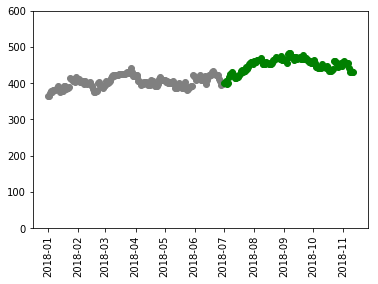

In [33]:
# Set the dates and new df.
rise_datelist = pd.date_range(start='1/1/2018', end='11/11/2018', freq='D').tolist()
rise_dates_df = pd.DataFrame({'date':rise_datelist})
# Separate out the Ms and count them.
rise_mis_df = counts_df.loc[counts_df.offense_class.str.endswith('M', na=False)] 
rise_dates_df['detainees'] = [rise_mis_df.download_date.loc[rise_mis_df.download_date == date].count() 
                         if rise_mis_df.download_date.loc[rise_mis_df.download_date == date].count() > 0
                         else np.nan for date in rise_dates_df.date]
rise_dates_df['detainees'] = rise_dates_df['detainees'].fillna(method='ffill')

# Set before and during rise (using all of 2018 to show the relevant increase).
rise_before = rise_dates_df.loc[rise_dates_df.date < '2018-07-01']
rise_during = rise_dates_df.loc[rise_dates_df.date >= '2018-07-01']

# Plot the count of misdemeanor detainees for the two time periods.
_ = plt.plot_date(x='date', y='detainees', data=rise_before, color='gray')
_ = plt.plot_date(x='date', y='detainees', data=rise_during, color='green')
_ = plt.ylim(0, 600)
_ = plt.xticks(rotation=90)